In [6]:
# 1️⃣ Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                           recall_score, f1_score, roc_auc_score, roc_curve, 
                           precision_recall_curve, average_precision_score)
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import numpy as np

In [7]:

# 2️⃣ Load Dataset
# Make sure your dataset path is correct and do not use this \, it will cause errors
df = pd.read_csv("D:/FYP/data/datasets/final_dataset_02.csv")


In [8]:
# 3️⃣ Prepare Features (X) and Target (y)
X = df.drop(columns=['label'])  # All features except label
y = df['label'].astype(int)     # Ensure labels are integer type (0: normal, 1: malicious)

# 4️⃣ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
# 5️⃣ Convert data to LightGBM's Dataset format (Native API)
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data, free_raw_data=False)


In [11]:
# 6️⃣ Define LightGBM Parameters (Native API)
params = {
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],  # Multiple metrics for better monitoring
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,              # Prevent overfitting
    'feature_fraction': 0.8,             # Random feature selection
    'bagging_fraction': 0.8,             # Random data selection
    'bagging_freq': 5,
    'verbosity': 1,
    'seed': 42,
    'early_stopping_round': 50           # Native API parameter
}

# 7️⃣ Train the model with Native API
lightgbm_model = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[valid_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=100),
        
    ]
)

[LightGBM] [Info] Number of positive: 53542, number of negative: 53541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1673
[LightGBM] [Info] Number of data points in the train set: 107083, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500005 -> initscore=0.000019
[LightGBM] [Info] Start training from score 0.000019
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 1	valid_0's binary_logloss: 0.221885


In [12]:
# 8️⃣ Make Predictions (Native API)
y_pred_proba = lightgbm_model.predict(X_test)  # Already returns probabilities for class 1
y_pred = (y_pred_proba > 0.5).astype(int)     # Convert to binary predictions

In [13]:
# 9️⃣  Evaluate model
# 1. Calculate all metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Note: Using probabilities
average_precision = average_precision_score(y_test, y_pred_proba)

# 2. Generate comprehensive classification report
print("📊 STATE-OF-THE-ART MODEL EVALUATION METRICS")
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall/Sensitivity: {recall:.4f}")
print(f" F1-Score: {f1:.4f}")
print(f" ROC-AUC: {roc_auc:.4f}")
print(f" Average Precision: {average_precision:.4f}\n")

📊 STATE-OF-THE-ART MODEL EVALUATION METRICS
 Accuracy: 1.0000
 Precision: 1.0000
 Recall/Sensitivity: 0.9999
 F1-Score: 1.0000
 ROC-AUC: 1.0000
 Average Precision: 1.0000



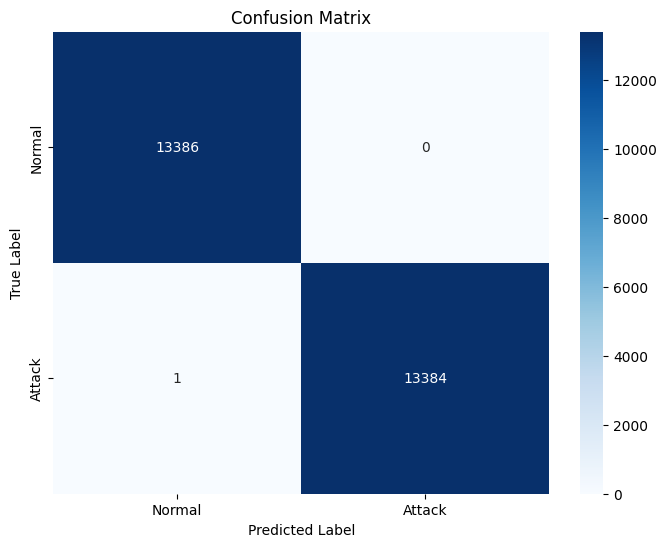

In [14]:
# 3. Enhanced Confusion Matrix with visualization
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

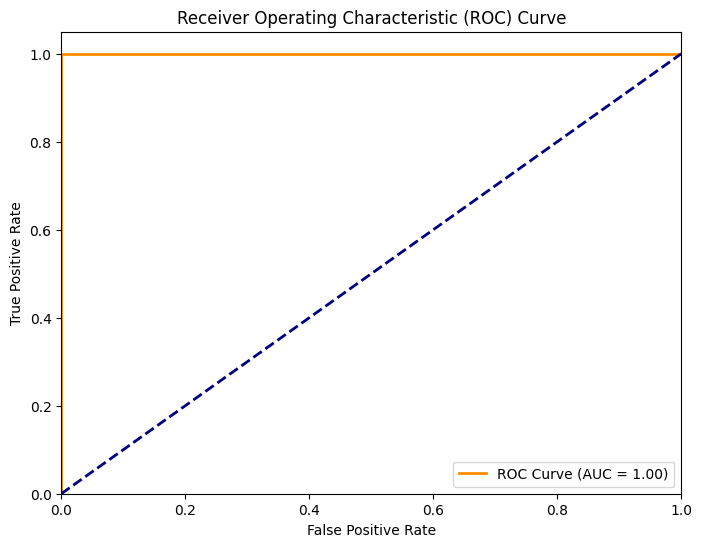

In [15]:
# 4. ROC Curve visualization
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

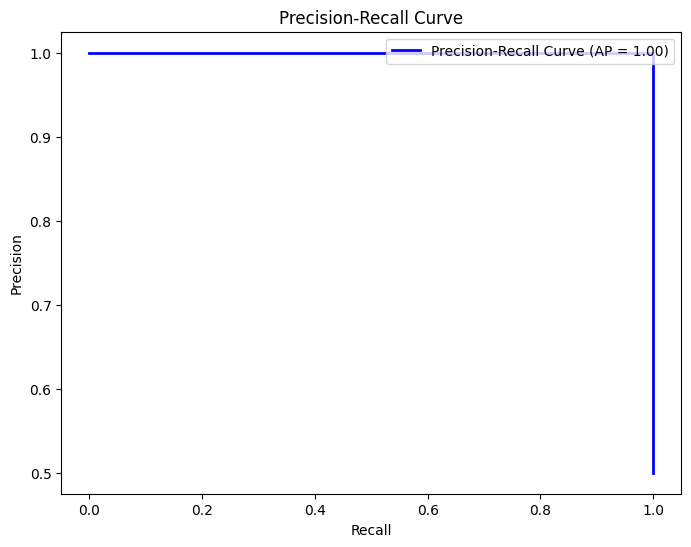

In [16]:
# 5. Precision-Recall Curve (especially important for imbalanced data)
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='blue', lw=2,
         label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

In [17]:

# 🔟 Save the Trained Model in .pkl Format
os.makedirs("D:/FYP/models/trained_models", exist_ok=True)  # Create directory if needed
joblib.dump(lightgbm_model, "D:/FYP/models/trained_models/lightgbm_intrusion_detection.pkl")
print("✅ Model saved successfully at: D:/FYP/models/trained_models/lightgbm_intrusion_detection.pkl")
lightgbm_model.save_model("D:/FYP/models/trained_models/lightgbm_native_model.txt") # Save the model in native format as well
print("✅ Model saved successfully in native format at: D:/FYP/models/trained_models/lightgbm_native_model.txt")

✅ Model saved successfully at: D:/FYP/models/trained_models/lightgbm_intrusion_detection.pkl
✅ Model saved successfully in native format at: D:/FYP/models/trained_models/lightgbm_native_model.txt
